<a href="https://colab.research.google.com/github/diem-ai/Azure-Computer-Vision/blob/master/src/collaborative_filtering_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive

from google.colab import drive
# This will prompt for authorization.
# authorization code: 4/OwErfUj6QceGXhIGx_RWv0MKclb9rilw8UsJnZqFbSez-QS8zQ399JU
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:

# visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# save files
from joblib import dump
from joblib import load

# vectorization
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# import my python class
my_module = drive.CreateFile({'id':'1uGOD2rFYVL9mods0KIpU_oY2Ye6fl8KE'})
my_module.GetContentFile('recommender.py')

import recommender
from recommender import Utility as utility
from recommender import Similarity as similarity

# text processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import re
import string

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
datapath = '/content/drive/My Drive/Colab Notebooks/movie_recommender/data/'
metadatapath = '/content/drive/My Drive/Colab Notebooks/movie_recommender/metadata/'

In [ ]:
#movies = pd.read_csv(datapath + 'name.basics.tsv', delimiter='\t', usecols=['t'])

ratings = pd.read_csv(datapath + 'title.ratings.tsv', delimiter='\t')

movies_ratings = pd.read_csv(datapath + 'title.principals.tsv', delimiter='\t', usecols=['tconst', 'nconst'])

movies_ratings = movies_ratings.merge(ratings, how='left', on='tconst')


In [ ]:
# drop duplicated movies and keep only the first one in the list
movies_ratings = movies_ratings.drop_duplicates(['tconst'], keep='first')

In [ ]:
movies_ratings = movies_ratings.dropna()

movies_ratings = movies_ratings.sort_values(by=['averageRating'], ascending=False)

In [ ]:
movies_ratings[:10]

,tconst,nconst,averageRating,numVotes
23754641,tt4758224,nm2820701,10.0,6.0
28795096,tt7028090,nm3204856,10.0,6.0
4133297,tt0579809,nm0498294,10.0,5.0
23730512,tt4743262,nm2820701,10.0,5.0
22591739,tt4216662,nm5320755,10.0,5.0
23730514,tt4743264,nm2820701,10.0,5.0
23755282,tt4758526,nm1477426,10.0,6.0
27224770,tt6325340,nm8639181,10.0,11.0
23754332,tt4758006,nm2820701,10.0,6.0
23730546,tt4743272,nm2820701,10.0,5.0


In [ ]:
movies_ratings.tconst = movies_ratings.tconst.apply(lambda movid : movid.replace('tt',''))
movies_ratings.nconst = movies_ratings.nconst.apply(lambda uid : uid.replace('nm',''))
movies_ratings.tconst = movies_ratings.tconst.astype(int)
movies_ratings.nconst = movies_ratings.nconst.astype(int)

#ratings_matrix = movies_ratings.pivot(index='tconst', columns='nconst', values='averageRating')


In [ ]:
len(movies_ratings)

978474

In [ ]:
#dump(movies_ratings, metadatapath + 'ratings.matrix')

In [ ]:
#!pip install pandas==0.21

In [ ]:
#ratings_mx = movies_ratings.head(10000).groupby(['nconst','tconst'])['averageRating'].max().unstack()
ratings_mx = movies_ratings.head(10000).pivot(index='tconst', columns='nconst', values='averageRating').fillna(0)

In [ ]:
movies_ratings.head()

,tconst,nconst,averageRating,numVotes
23754641,4758224,2820701,10.0,6.0
28795096,7028090,3204856,10.0,6.0
4133297,579809,498294,10.0,5.0
23730512,4743262,2820701,10.0,5.0
22591739,4216662,5320755,10.0,5.0


In [ ]:
ratings_mx.head()

nconst,2,7,8,9,12,14,23,73,83,96,100,116,125,138,146,173,188,225,228,274,276,306,330,341,370,386,407,476,489,541,603,607,614,638,658,663,670,691,714,718,...,10921259,10922516,10926044,10926646,10938752,10947376,10962218,10965970,10977309,10979745,10980680,11009597,11019362,11022027,11023607,11028351,11030375,11039428,11043453,11044370,11046120,11054327,11064317,11077363,11090142,11101185,11101487,11108201,11108267,11108517,11108857,11110041,11112068,11121072,11126742,11128343,11128941,11131140,11131591,11134210
tconst,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

n_components = 2000#ratings_mx.shape[1]
print("Best number for TSVD: {} ".format(n_components))
svd = TruncatedSVD(n_components=(n_components-1))
latent_rating = svd.fit_transform(ratings_mx)
print(latent_rating[:5])


Best number for TSVD: 2000 
[[-4.64750973e-13 -8.08822963e-14 -5.06459136e-13 ...  6.14280749e-03
   3.32628834e-03  7.38042937e-03]
 [ 3.07743297e-13  4.40314380e-13  4.10258981e-13 ... -6.04706357e-02
  -1.40333524e-03 -1.61538971e-01]
 [-4.39190850e-14  5.03708125e-14 -9.14498700e-15 ...  3.07437544e-01
   2.48115072e-03 -3.99484027e-03]
 [ 8.32216837e-14 -4.86211574e-14  3.39801200e-14 ...  1.15492741e-01
   3.05018887e-02 -4.83127726e-03]
 [-3.35519862e-15 -1.33919207e-15 -3.90201176e-15 ...  3.53420809e-05
  -7.20435607e-05  3.98394197e-05]]


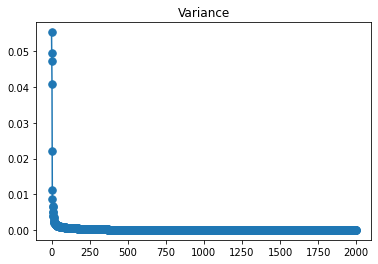

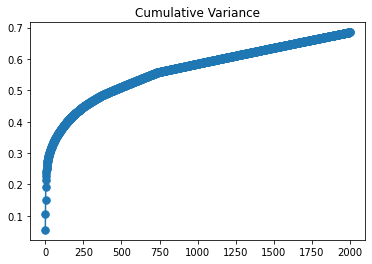

In [ ]:
# plot variance and cumulative variance for content based matrix
expl = svd.explained_variance_ratio_
plt.plot(expl, '.-', ms=15)
plt.title('Variance');
plt.show()

plt.plot(np.cumsum(expl), '.-', ms=15)
plt.title('Cumulative Variance');
plt.show()

In [ ]:
latent_rating_matrix = pd.DataFrame(latent_rating, index=ratings_mx.index.tolist())

In [ ]:
latent_rating_matrix.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
15927,-4.647510e-13,-8.088230e-14,-5.064591e-13,-1.933600e-13,-2.046321e-13,-8.242077e-12,5.636941e-11,-1.921812e-10,-1.578980e-10,4.402874e-10,-7.613457e-10,-3.389417e-09,3.194814e-09,-5.633373e-10,-9.074276e-10,2.037027e-08,-1.758734e-08,-7.881446e-08,6.173137e-08,-3.329568e-09,-1.756297e-08,1.198175e-07,-2.473678e-08,3.757122e-08,-4.271271e-08,-2.930158e-08,2.029109e-07,-5.562360e-07,2.834767e-07,-2.923942e-07,1.904019e-07,-4.815242e-07,2.554920e-07,3.726434e-08,2.155104e-07,-3.068613e-07,-2.984325e-08,6.361702e-07,3.692263e-07,5.699004e-07,...,-0.058926,0.142247,-0.131425,0.272614,0.145445,-0.020352,-0.016045,-0.130297,0.084077,0.123228,0.153094,0.259683,-0.040754,0.100894,-0.052629,0.083409,0.102208,-0.298333,-0.036166,-0.127154,-0.016842,0.350654,0.204345,-0.002082,-0.056465,-0.137097,0.120415,-0.042162,0.066100,-0.042535,-0.064083,-0.104607,0.029728,0.044826,0.259382,-0.171386,0.222345,0.006143,0.003326,0.007380
50536,3.077433e-13,4.403144e-13,4.102590e-13,4.697610e-14,-1.464845e-13,-8.054169e-12,-3.335554e-12,-9.411139e-11,3.527030e-10,3.695002e-10,5.744170e-11,1.239601e-09,1.600967e-09,-2.515725e-09,6.964458e-09,-2.198658e-10,7.420257e-09,2.068374e-08,2.867408e-08,-3.566106e-08,1.234812e-08,2.914731e-08,9.896124e-08,2.483248e-08,7.790111e-08,1.672275e-08,5.822582e-08,5.227658e-09,-4.088940e-08,1.637167e-07,-1.216472e-07,-2.923763e-08,-5.666878e-07,8.585887e-08,-7.714822e-07,-8.729510e-07,-7.766170e-07,-6.199185e-08,1.452905e-06,3.753411e-07,...,-0.013394,-0.098387,0.131951,-0.271206,-0.070816,-0.119824,-0.066909,0.310148,-0.090587,-0.264797,-0.120277,-0.069316,0.037503,-0.217260,-0.010321,-0.028735,0.140744,0.015960,-0.185367,0.128413,0.064046,-0.147677,0.006773,-0.127608,-0.081471,0.200193,0.056470,-0.131098,0.237845,0.026996,0.026636,-0.120291,0.127837,-0.001564,0.183801,0.057528,0.079385,-0.060471,-0.001403,-0.161539
53560,-4.391908e-14,5.037081e-14,-9.144987e-15,-1.639807e-14,3.807081e-13,2.048341e-11,-2.332785e-11,2.470891e-10,-5.490459e-10,5.918828e-10,6.146801e-10,-1.119972e-09,-3.464589e-09,1.509457e-09,-3.924857e-09,-6.885931e-09,3.361576e-09,1.748684e-08,-1.094499e-09,-2.741726e-08,-1.966837e-08,2.510265e-08,-1.011570e-08,-1.442965e-07,-1.313892e-07,-3.499563e-07,5.066822e-08,-6.249045e-08,3.327349e-08,4.460117e-07,-2.484442e-07,-4.506425e-07,5.347487e-07,-5.546179e-07,8.563127e-08,-7.844847e-07,-1.603596e-07,-6.723209e-07,-1.310091e-06,-1.947511e-07,...,-0.080549,0.507785,-0.011155,-0.049829,0.133196,-0.029460,-0.179692,-0.345575,-0.048878,0.112947,0.091401,0.259666,0.099845,0.239099,0.305436,0.027390,-0.001608,0.063753,0.586292,0.077821,0.050335,0.110021,-0.085375,-0.407185,0.020744,-0.119352,-0.125431,-0.004351,0.015357,0.169157,-0.069347,0.220051,0.000067,0.200662,0.034168,0.425364,0.099740,0.307438,0.002481,-0.003995
57955,8.322168e-14,-4.862116e-14,3.398012e-14,-2.389851e-14,4.308622e-13,-2.051435e-12,4.880254e-11,-2.078201e-10,-1.885040e-10,-3.261300e-11,2.133505e-10,-4.271536e-09,-1.240813e-09,1.458307e-09,-1.785548e-09,3.956192e-08,7.314745e-09,-3.081773e-08,-4.648872e-08,1.163305e-08,-1.135070e-08,3.903410e-08,1.219648e-07,-4.326292e-08,1.280971e-07,-7.087804e-08,-1.873676e-07,4.327792e-07,1.318735e-07,2.557319e-08,-6.655082e-07,3.343485e-07,-3.925459e-07,6.441470e-08,-6.483769e-08,3.336507e-07,-8.935124e-07,-2.883401e-07,-4.073954e-07,1.551735e-07,...,-0.088043,-0.082643,-0.008593,0.050145,-0.006840,0.014518,0.103958,0.129748,-0.017987,-0.041973,-0.110515,0.043567,0.115158,0.000715,0.139534,-0.012593,-0.134105,-0.120721,0.078837,-0.024508,-0.130776,-0.001094,0.002370,-0.056495,-0.011136,-0.147274,0.018084,0.069359,0.024360,-0.055221,-0.005294,-0.088664,-0.134243,0.056713,-0.097260,0.07383

In [ ]:
movies = pd.read_csv(datapath + 'title.basics.tsv', delimiter='\t')
movies.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
seed_movie = 57955

print(movies.iloc[seed_movie])

features = ['primaryTitle', 'genres', 'startYear','score']

similarity.make_recommendation(seed_movie, latent_rating_matrix, movies, features, 10)

tconst                                  tt0059054
titleType                                   movie
primaryTitle                               Balboa
originalTitle     Los conquistadores del Pacífico
isAdult                                         0
startYear                                    1963
endYear                                        \N
runtimeMinutes                                 96
genres                          Adventure,History
Name: 57955, dtype: object
                          primaryTitle                genres startYear   score
5106610    Secret Black People Meeting             Talk-Show      2017  0.0800
3222278                        Takkyuu                    \N      1977  0.0769
5874198                   Episode #1.1         Drama,Romance      2018  0.0765
346636         Cazando a un millonario  Comedy,Drama,Romance      2001  0.0742
736684            Last Girl Standing 2         Drama,Romance      2004  0.0737
15927                   El niño de oro           